# **Diabetic Retinopathy Detection**
****Identify signs of diabetic retinopathy in eye images****


Diabetic retinopathy is the leading cause of blindness in the working-age population of the developed world. It is estimated to affect over 93 million people.

![](https://storage.googleapis.com/kaggle-competitions/kaggle/4104/media/retina.jpg)


The US Center for Disease Control and Prevention estimates that 29.1 million people in the US have diabetes and the World Health Organization estimates that 347 million people have the disease worldwide. Diabetic Retinopathy (DR) is an eye disease associated with long-standing diabetes. Around 40% to 45% of Americans with diabetes have some stage of the disease. Progression to vision impairment can be slowed or averted if DR is detected in time, however this can be difficult as the disease often shows few symptoms until it is too late to provide effective treatment.

Currently, detecting DR is a time-consuming and manual process that requires a trained clinician to examine and evaluate digital color fundus photographs of the retina. By the time human readers submit their reviews, often a day or two later, the delayed results lead to lost follow up, miscommunication, and delayed treatment.

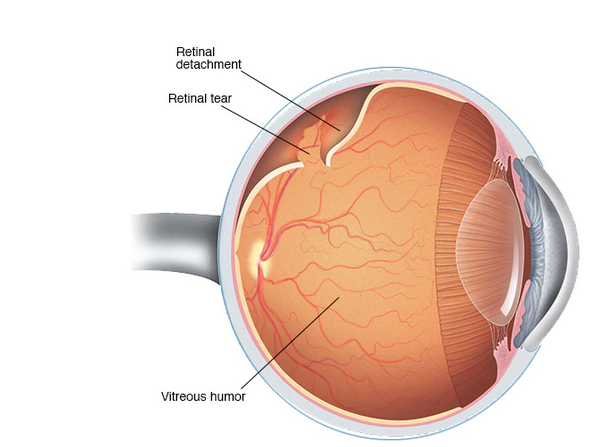

Clinicians can identify DR by the presence of lesions associated with the vascular abnormalities caused by the disease. While this approach is effective, its resource demands are high. The expertise and equipment required are often lacking in areas where the rate of diabetes in local populations is high and DR detection is most needed. As the number of individuals with diabetes continues to grow, the infrastructure needed to prevent blindness due to DR will become even more insufficient.

The need for a comprehensive and automated method of DR screening has long been recognized, and previous efforts have made good progress using image classification, pattern recognition, and machine learning. With color fundus photography as input, the goal of this competition is to push an automated detection system to the limit of what is possible – ideally resulting in models with realistic clinical potential. 

DR: Diabetic Retinopathy

https://www.kaggle.com/competitions/diabetic-retinopathy-detection

# ****About Dataset****
****About the Data****

The images consist of gaussian filtered retina scan images to detect diabetic retinopathy. The original dataset is available at APTOS 2019 Blindness Detection. These images are resized into 224x224 pixels so that they can be readily used with many pre-trained deep learning models.

All of the images are already saved into their respective folders according to the severity/stage of diabetic retinopathy using the train.csv file provided. You will find five directories with the respective images:

****0 - No_DR****

****1 - Mild****

****2 - Moderate****

****3 - Severe****

****4 - Proliferate_DR****



# ****Understanding the Stages of Diabetic Retinopathy****

Elevated blood sugar, blood pressure and cholesterol levels and increased body weight are associated with uncontrolled diabetes and can damage the delicate blood vessels of the retina, causing a disease called diabetic retinopathy. In the early stages of diabetic retinopathy, vision loss may be prevented or limited; but as the condition advances, it becomes more difficult to prevent vision loss.

![](https://www.elmanretina.com/wp-content/uploads/shutterstock_657947524-1024x700.jpg)

****Non-Proliferative Retinopathy****

Non-proliferative diabetic retinopathy is the earlier and less serious stage of the disease. Due to damage from elevated blood sugar levels, the tiny blood vessels of the retina start to swell and leak fluid and blood. The leaking causes swelling inside the retina called macular edema, which is a common cause of visual impairment in people with diabetes.

As non-proliferative retinopathy advances, the blood vessels may become blocked or closed off, and new abnormal blood vessels may start to grow and form in the wrong parts of the retina. Vision is usually unaffected in the non-proliferative stages, but it is best for the retina doctor to watch these changes closely every few months to ensure it doesn’t worsen to the “proliferative” stage.

****Proliferative Diabetic Retinopathy****

The more serious form of the disease, proliferative diabetic retinopathy is characterized by a process known as neovascularization. When the blood vessels of the retina become blocked, the retina is deprived of the oxygen and nutrients it needs to thrive. Sensing its limited blood supply, the retina responds by growing new abnormal blood vessels in the wrong parts of the retina. But the new blood vessels are abnormal and do not provide proper blood flow. They are extremely fragile and, as they grow, can leak blood into the vitreous. Sometimes this bleeding causes visual distortions called floaters; if the bleeding is severe enough, it can partially or completely impair vision.

In some cases, the formation of the new, abnormal blood vessels leads to the development of scar tissue, or fibrosis, in the retina. Scar tissue may cause the retina to wrinkle or “pucker,” or even detach from its normal position along the back of the eye, which is referred to as “tractional retinal detachment.” Depending on the complication, central vision loss can occur.

Another complication to watch out for is the growth of these abnormal blood vessels blocking the drainage angle, the natural mechanism by which fluid exits the eye. If this occurs, pressure inside the eye can spike very quickly, causing neovascular angle-closure glaucoma.


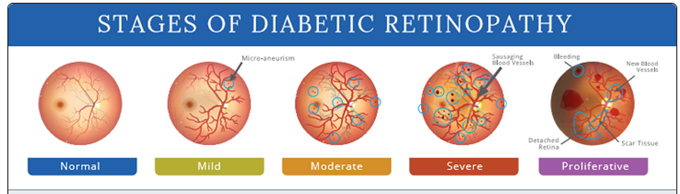

![](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/4e2ccbd15cc04a08c9a096424043c4aee7c4388b/2-Figure1-1.png)

In [50]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [310]:
# Add an additional column, mapping to the type
df = pd.read_csv(r'../input/diabetic-retinopathy-224x224-gaussian-filtered/train.csv')

diagnosis_dict_binary = {
    0: 0,
    1: 1,
    2: 1,
    3: 1,
    4: 1
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

id_code  diagnosis  binary_type            type
0  000c1434d8d7          2            1        Moderate
1  001639a390f0          4            1  Proliferate_DR
2  0024cdab0c1e          1            1            Mild
3  002c21358ce6          0            0           No_DR
4  005b95c28852          0            0           No_DR

<AxesSubplot:>

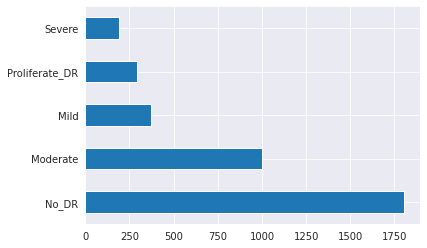

In [311]:
df['type'].value_counts().plot(kind='barh')

<AxesSubplot:>

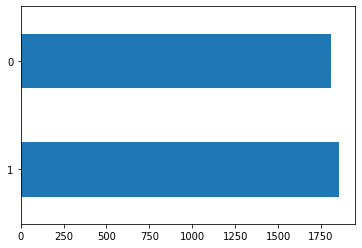

In [53]:
df['binary_type'].value_counts().plot(kind='barh')

In [265]:
sdir=r'../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'
classlist=os.listdir(sdir)    
filepaths=[]
labels=[]    
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)        
        for f in flist:
            fpath=os.path.join(classpath,f)        
            filepaths.append(fpath)
            labels.append(klass)
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)    
print (df.head())
print('df length: ', len(df))
print (df['labels'].value_counts())

                                           filepaths labels
0  ../input/diabetic-retinopathy-224x224-gaussian...   Mild
1  ../input/diabetic-retinopathy-224x224-gaussian...   Mild
2  ../input/diabetic-retinopathy-224x224-gaussian...   Mild
3  ../input/diabetic-retinopathy-224x224-gaussian...   Mild
4  ../input/diabetic-retinopathy-224x224-gaussian...   Mild
df length:  3662
No_DR             1805
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
Name: labels, dtype: int64


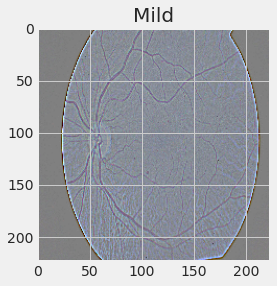

In [351]:
img1 = cv2.imread("../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/0124dffecf29.png")
plt.imshow(img1)
plt.title("Mild")
plt.show()

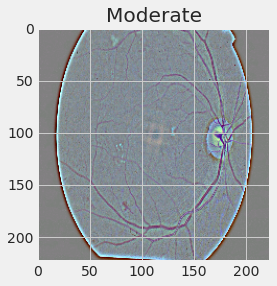

In [352]:
img1 = cv2.imread("../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Moderate/0161338f53cc.png")
plt.imshow(img1)
plt.title("Moderate")
plt.show()

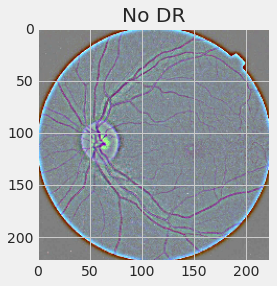

In [353]:
img1 = cv2.imread("../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/No_DR/00cc2b75cddd.png")
plt.imshow(img1)
plt.title("No DR")
plt.show()

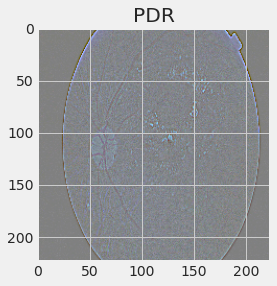

In [354]:
img1 = cv2.imread("../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Proliferate_DR/034cb07a550f.png")
plt.imshow(img1)
plt.title("PDR")
plt.show()

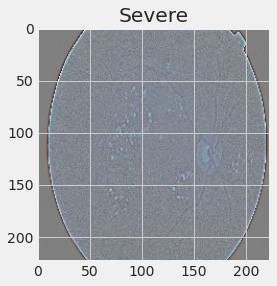

In [355]:
img1 = cv2.imread("../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Severe/042470a92154.png")
plt.imshow(img1)
plt.title("Severe")
plt.show()

## Down sample class "No DR"  from 1805 to 1500  

In [268]:
sample_list=[]
max_size= 1500
groups=df.groupby('labels')
for label in df['labels'].unique():                 
    group=groups.get_group(label)
    sample_count=len(group)    
    if sample_count> max_size:
        samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
    else:
        samples=group.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)
    sample_list.append(samples)
df=pd.concat(sample_list, axis=0).reset_index(drop=True)
print (len(df))     
print (df['labels'].value_counts())

3357
No_DR             1500
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
Name: labels, dtype: int64


## Creating work Directory

In [269]:
working_dir=r'./'
aug_dir=os.path.join(working_dir, 'aug')
if os.path.isdir(aug_dir):
    shutil.rmtree(aug_dir)
os.mkdir(aug_dir)
for label in df['labels'].unique():
    dir_path=os.path.join(aug_dir,label)    
    os.mkdir(dir_path)
print(os.listdir(aug_dir))

['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']


## Augmentation

In [270]:
target=1500 # set the target count for each class in df
gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                              height_shift_range=.2, zoom_range=.2)
groups=df.groupby('labels') # group by class
for label in df['labels'].unique():  # for every class               
    group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
    sample_count=len(group)   # determine how many samples there are in this class  
    if sample_count< target: # if the class has less than target number of images
        aug_img_count=0
        delta=target-sample_count  # number of augmented images to create
        target_dir=os.path.join(aug_dir, label)  # define where to write the images    
        aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=(224,224), class_mode=None,
                                        batch_size=1, shuffle=False, save_to_dir=target_dir, save_prefix='aug-',
                                        save_format='jpg')
        while aug_img_count<delta:
            images=next(aug_gen)            
            aug_img_count += len(images) 

Found 370 validated image filenames.
Found 295 validated image filenames.
Found 999 validated image filenames.
Found 193 validated image filenames.


In [271]:
aug=r'./aug'
auglist=os.listdir(aug)
print (auglist)
for klass in auglist:
    classpath=os.path.join(aug, klass)
    flist=os.listdir(classpath)
    print('class: ', klass, '  file count: ', len(flist))

['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']
klass:  No_DR   file count:  0
klass:  Mild   file count:  1130
klass:  Moderate   file count:  501
klass:  Severe   file count:  1307
klass:  Proliferate_DR   file count:  1205


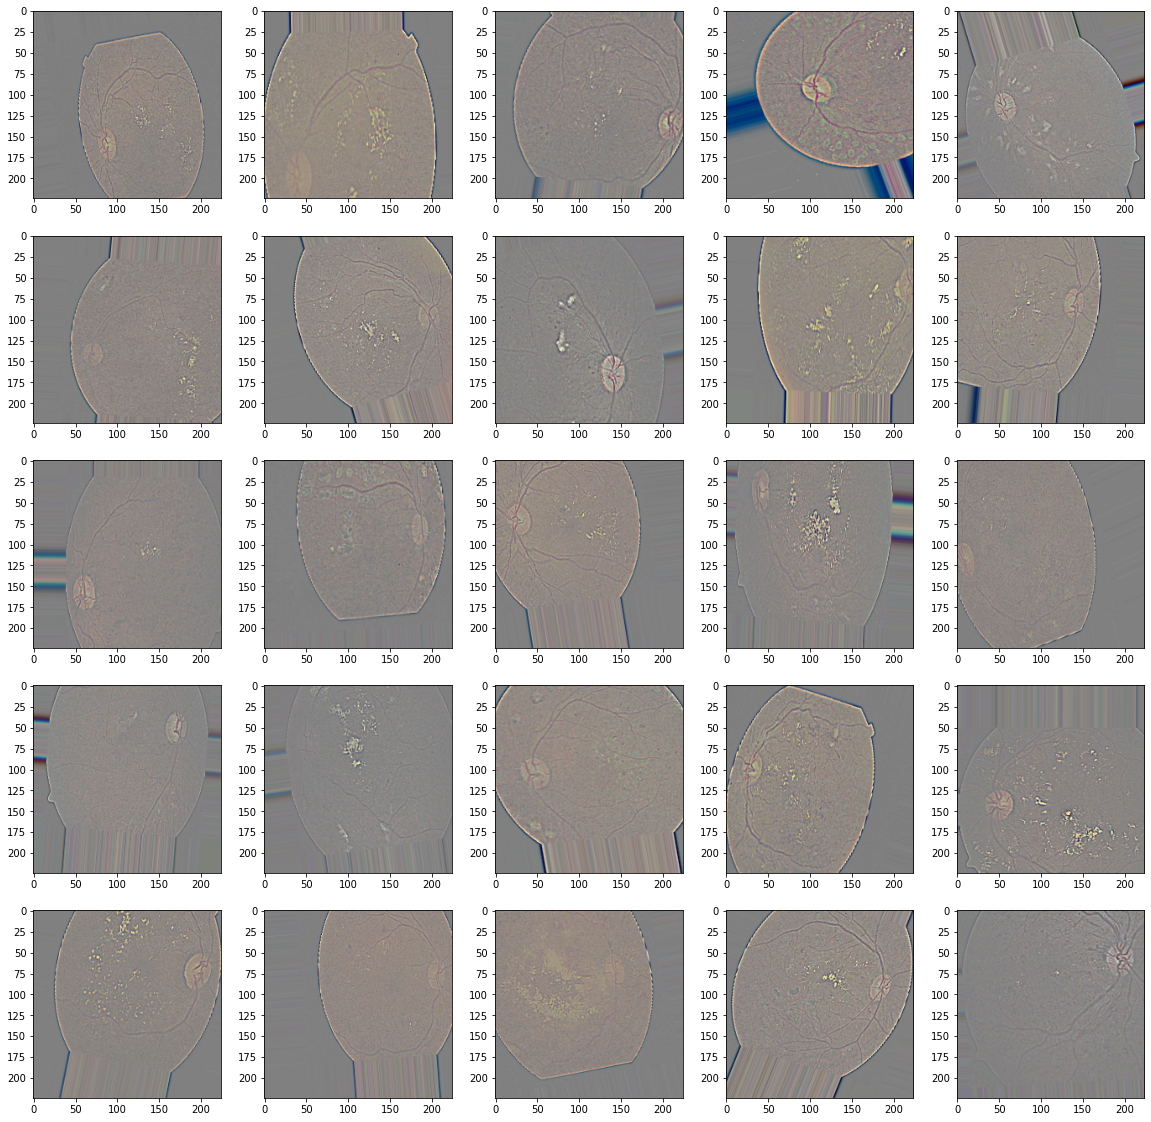

In [273]:
plt.figure(figsize=(20, 20))
for i in range(25):
    image=next(aug_gen)/255
    image=np.squeeze(image, axis=0)
    plt.subplot(5,5,i+1)
    plt.imshow(image)
plt.show()

In [274]:
aug_fpaths=[]
aug_labels=[]
classlist=os.listdir(aug_dir)
for klass in classlist:
    classpath=os.path.join(aug_dir, klass)     
    flist=os.listdir(classpath)    
    for f in flist:        
        fpath=os.path.join(classpath,f)         
        aug_fpaths.append(fpath)
        aug_labels.append(klass)
Fseries=pd.Series(aug_fpaths, name='filepaths')
Lseries=pd.Series(aug_labels, name='labels')
aug_df=pd.concat([Fseries, Lseries], axis=1)
ndf=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
#ndf=df.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)


print (df['labels'].value_counts()) 
print(aug_df['labels'].value_counts())
print (ndf['labels'].value_counts()) 

No_DR             1500
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
Name: labels, dtype: int64
Severe            1357
Proliferate_DR    1205
Mild              1130
Moderate           501
Name: labels, dtype: int64
Severe            1550
Mild              1500
Proliferate_DR    1500
Moderate          1500
No_DR             1500
Name: labels, dtype: int64


In [275]:
ndf.head()

filepaths labels
0  ../input/diabetic-retinopathy-224x224-gaussian...   Mild
1  ../input/diabetic-retinopathy-224x224-gaussian...   Mild
2  ../input/diabetic-retinopathy-224x224-gaussian...   Mild
3  ../input/diabetic-retinopathy-224x224-gaussian...   Mild
4  ../input/diabetic-retinopathy-224x224-gaussian...   Mild

## train_test_split

In [277]:
train_split=.8
valid_split=.1
dummy_split=valid_split/(1-train_split)
train_df, dummy_df=train_test_split(ndf, train_size=train_split, shuffle=True, random_state=123)
valid_df, test_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df),'  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))


train_df length:  6040   test_df length:  755   valid_df length:  755


## Generators

In [278]:
height=224
width=224
channels=3
batch_size=40
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    #img=img/127.5-1
    return img 
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(len(train_gen.labels)/batch_size)

test batch size:  5   test steps:  151
Found 6040 validated image filenames belonging to 5 classes.
Found 755 validated image filenames belonging to 5 classes.
Found 755 validated image filenames belonging to 5 classes.


In [281]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='green', fontsize=16)
        plt.axis('off')
    plt.show()

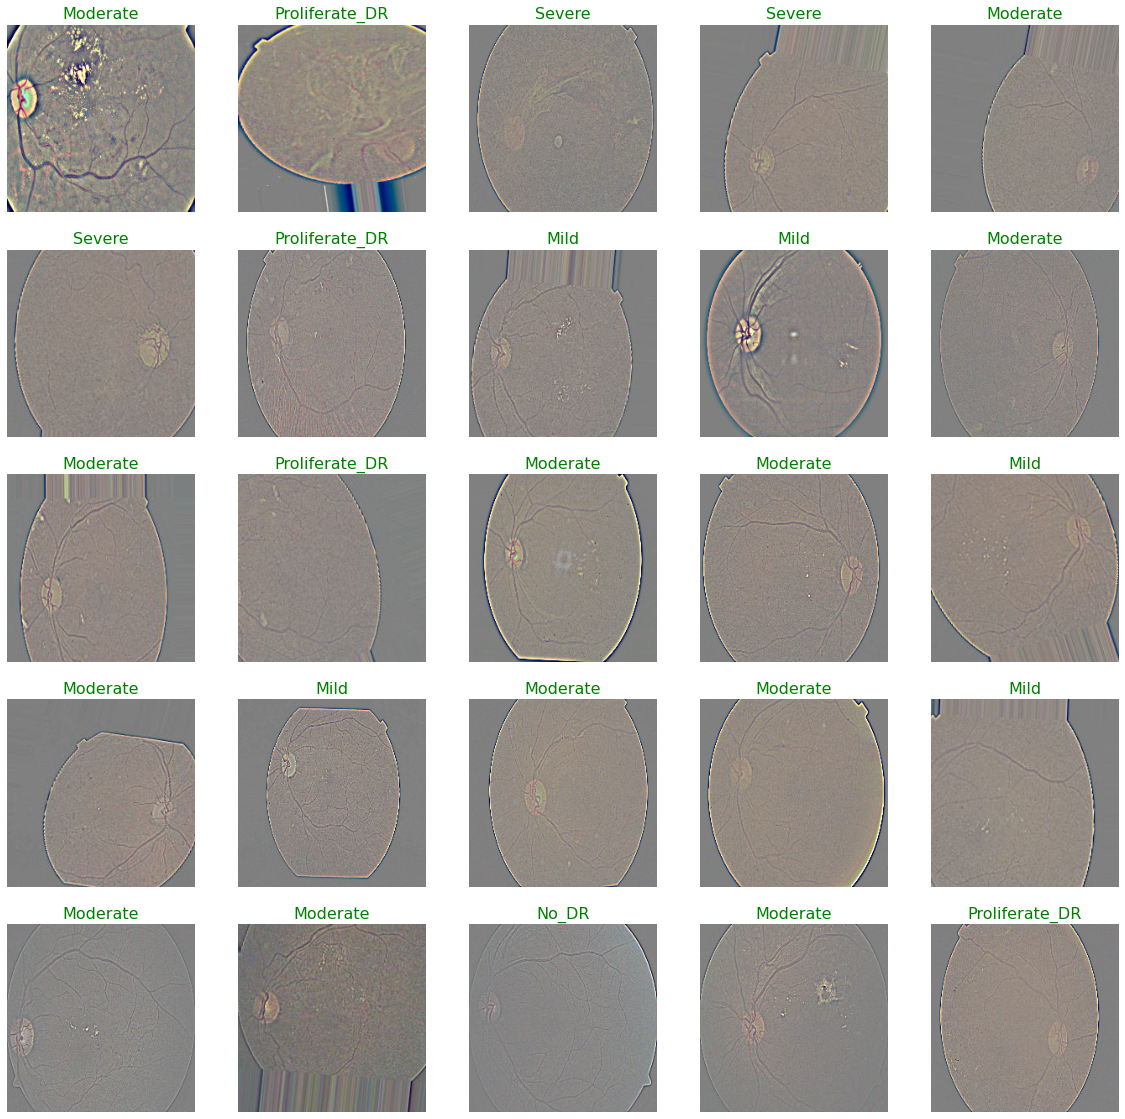

In [282]:
show_image_samples(train_gen)


In [299]:
class LRA(keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0
    
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze,batches, initial_epoch,epochs, ask_epoch):
        super(LRA, self).__init__()
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.model=model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it in self.lr
        self.highest_tracc=0.0 # set highest training accuracy to 0
        self.lowest_vloss=np.inf # set lowest validation loss to infinity
        #self.count=0 # initialize counter that counts epochs with no improvement
        #self.stop_count=0 # initialize counter that counts how manytimes lr has been adjustd with no improvement  
        self.initial_epoch=initial_epoch 
        self.batches=batches
        #self.epochs=epochs
        best_weights=self.model.get_weights() # set a class vaiable so weights can be loaded after training is completed        
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name} training all layers '            
        print_in_color (msgs, (244, 252, 3), (55,65,80)) 
    def on_train_begin(self, logs=None):
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
        print_in_color(msg, (244,252,3), (55,65,80)) 
    def on_train_end(self, logs=None):
        model.set_weights(LRA.best_weights)
        msg='Training is completed - model is set with weights for the epoch with the lowest loss'
        print_in_color(msg, (0,255,0), (55,65,80)) 
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy 
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count
        
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        #print ( '\n',v_loss, self.lowest_vloss, acc, self.highest_tracc)
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                LRA.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.lr=lr
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1:
                    color=(245, 170, 66)
                    self.lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                LRA.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)
                self.lr=lr
            else: # validation loss did not improve
                if self.count>=self.patience-1:
                    color=(245, 170, 66)
                    self.lr=self.lr * self.factor # adjust the learning rate                    
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,255), (55,65,80))
            self.model.stop_training = True # stop training
        else: 
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    msg='enter H to halt training or an integer for number of epochs to run then ask again'
                    print_in_color(msg, (0,255,255), (55,65,80))
                    ans=input('')
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print_in_color(msg, (0,255,255), (55,65,80))
                        self.model.stop_training = True # stop training
                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans
                           
                   

In [301]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [285]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

In [296]:
model_name='EfficientNetB1'
base_model=tf.keras.applications.EfficientNetB1(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(5, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_5 (Rescaling)         (None, 224, 224, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
normalization_5 (Normalization) (None, 224, 224, 3)  7           rescaling_5[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_5[0][0]            
____________________________________________________________________________________________

In [302]:
epochs =40
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=10 # number of epochs to run before asking if you want to halt training
batches=train_steps
callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name=model_name, freeze=freeze, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 Starting training using base model EfficientNetB1 training all layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration

 1 /40     5.333   66.589   4.70143  63.179   0.00100  0.00100  accuracy   63.37  

 2 /40     3.890   71.606   3.41283  68.609   0.00100  0.00100  accuracy   61.27  

 3 /40     2.828   78.013   2.60493  70.861   0.00100  0.00100  accuracy   61.55  

 4 /40     2.036   82.897   1.86415  78.278   0.00100  0.00100  accuracy   61.81  

 5 /40     1.450   87.699   1.47398  77.616   0.00100  0.00100  accuracy   62.47  

 6 /40     1.024   90.762   1.14270  79.735   0.00100  0.00100  val_loss   62.56  

 7 /40     0.755   93.063   1.12600  75.894   0.00100  0.00100  val_loss   63.63  

 8 /40     0.570   94.520   0.81888  82.781   0.00100  0.00100  val_loss   61.66  

 9 /40     0.451   95.530   0.71634  85.430   0.00100  0.00100  val_loss   61.49  

10 /40     0.388   96.060   0.76002  82.384   0.00100  0.00050  val_loss   63.74  

ente

 30


11 /40     0.359   97.136   0.63472  86.623   0.00050  0.00050  val_loss   62.74  

12 /40     0.317   97.930   0.63226  86.225   0.00050  0.00050  val_loss   62.42  

13 /40     0.277   98.659   0.57605  87.285   0.00050  0.00050  val_loss   62.75  

14 /40     0.257   98.510   0.59303  87.550   0.00050  0.00025  val_loss   62.87  

15 /40     0.260   98.742   0.54329  88.344   0.00025  0.00025  val_loss   60.69  

16 /40     0.241   98.858   0.53320  88.742   0.00025  0.00025  val_loss   60.72  

17 /40     0.230   98.974   0.53207  88.079   0.00025  0.00025  val_loss   60.31  

18 /40     0.220   99.139   0.53608  87.947   0.00025  0.00013  val_loss   60.98  

19 /40     0.214   99.387   0.51729  89.669   0.00013  0.00013  val_loss   62.93  

20 /40     0.215   99.040   0.51638  88.609   0.00013  0.00013  val_loss   62.93  

21 /40     0.210   99.123   0.51422  88.742   0.00013  0.00013  val_loss   62.84  

22 /40     0.204   99.238   0.50430  88.742   0.00013  0.00013  val_loss   6

In [ ]:
"""# Building the model

model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(5, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['acc'])

history = model.fit(x=train_gen,
                    epochs=30,
                    validation_data=valid_gen)"""

In [357]:
model.save('efficientnetb1.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


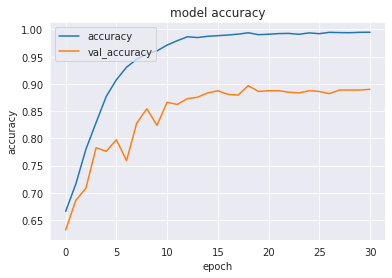

In [306]:
def display_accuracy() -> None:
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
    plt.show()
display_accuracy()

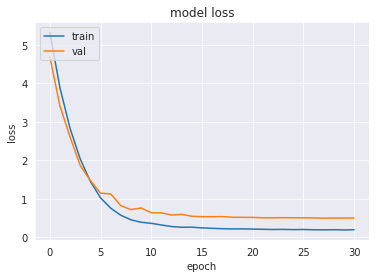

In [304]:
def display_loss() -> None:
    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
display_loss()

In [307]:
pred = model.predict(test_gen)

In [316]:
pred

array([[9.8890519e-01, 3.8932825e-03, 2.3841991e-03, 2.9025953e-03,
        1.9147578e-03],
       [2.7655673e-03, 2.8408458e-03, 9.8943198e-01, 2.5563492e-03,
        2.4052931e-03],
       [6.2294394e-02, 6.0429126e-01, 4.1861672e-02, 1.9303851e-01,
        9.8514192e-02],
       ...,
       [6.8666460e-04, 8.0605038e-04, 9.9712127e-01, 5.9884839e-04,
        7.8714627e-04],
       [4.7327629e-03, 4.3114019e-03, 9.8416555e-01, 3.2766759e-03,
        3.5135939e-03],
       [3.7024390e-02, 9.1857761e-03, 2.5883606e-03, 9.4495493e-01,
        6.2464261e-03]], dtype=float32)

In [319]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

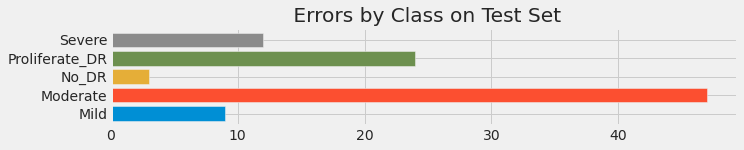

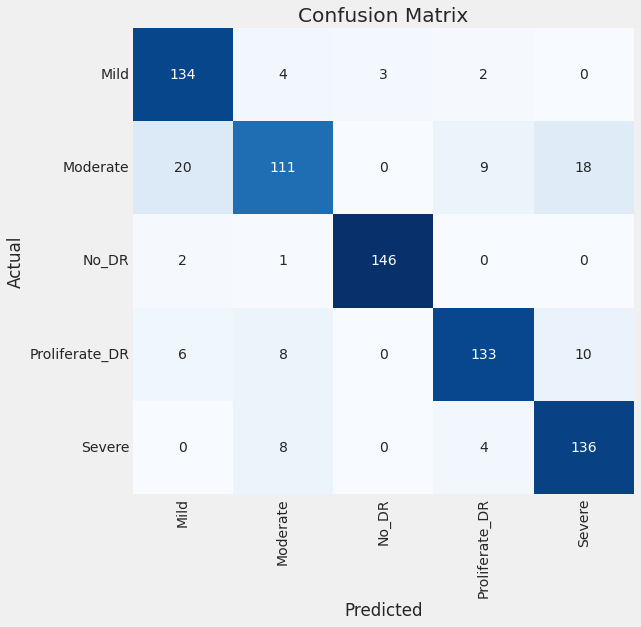

Classification Report:
----------------------
                 precision    recall  f1-score   support

          Mild       0.83      0.94      0.88       143
      Moderate       0.84      0.70      0.77       158
         No_DR       0.98      0.98      0.98       149
Proliferate_DR       0.90      0.85      0.87       157
        Severe       0.83      0.92      0.87       148

      accuracy                           0.87       755
     macro avg       0.88      0.88      0.87       755
  weighted avg       0.88      0.87      0.87       755



In [326]:
print_code = 0
save_dir = "./"
subject='classes'

print_info( test_gen, pred, print_code, save_dir, subject )  
